In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# get the data by creating the connection string
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
 # importing the data
query1 = '''SELECT f.film_id, f.title, c.name, f.rental_duration, f.length, f.rating, f.replacement_cost, f.special_features, rental_rate 
FROM film_category fc
JOIN film f 
ON fc.film_id = f.film_id
JOIN category c 
ON c.category_id = fc.category_id;'''

In [4]:
#  checking and reading the data
data1 = pd.read_sql_query(query1, engine) 
display (data1.head())
#data.tail()

,film_id,title,name,rental_duration,length,rating,replacement_cost,special_features,rental_rate
0,19,AMADEUS HOLY,Action,6,113,PG,20.99,"Commentaries,Deleted Scenes,Behind the Scenes",0.99
1,21,AMERICAN CIRCUS,Action,3,129,R,17.99,"Commentaries,Behind the Scenes",4.99
2,29,ANTITRUST TOMATOES,Action,5,168,NC-17,11.99,"Trailers,Commentaries,Deleted Scenes",2.99
3,38,ARK RIDGEMONT,Action,6,68,NC-17,25.99,"Trailers,Commentaries,Deleted Scenes,Behind th...",0.99
4,56,BAREFOOT MANCHURIAN,Action,6,129,G,15.99,"Trailers,Commentaries",2.99


In [5]:
# dropping unwanted columns and assigning data to 'X', as feature data
X = data1.drop(['title', 'film_id'], axis = 1)
X

,name,rental_duration,length,rating,replacement_cost,special_features,rental_rate
0,Action,6,113,PG,20.99,"Commentaries,Deleted Scenes,Behind the Scenes",0.99
1,Action,3,129,R,17.99,"Commentaries,Behind the Scenes",4.99
2,Action,5,168,NC-17,11.99,"Trailers,Commentaries,Deleted Scenes",2.99
3,Action,6,68,NC-17,25.99,"Trailers,Commentaries,Deleted Scenes,Behind th...",0.99
4,Action,6,129,G,15.99,"Trailers,Commentaries",2.99
...,...,...,...,...,...,...,...
995,Travel,7,48,PG-13,9.99,"Trailers,Behind the Scenes",0.99
996,Travel,3,85,R,25.99,"Deleted Scenes,Behind the Scenes",2.99
997,Travel,7,55,NC-17,13.99,Behind the Scenes,0.99
998,Travel,7,139,R,26.99,"Trailers,Commentaries,Behind the Scenes",2.99


# Data cleaning

In [6]:
# checking the shape and data types
X.shape
X.dtypes

name                 object
rental_duration       int64
length                int64
rating               object
replacement_cost    float64
special_features     object
rental_rate         float64
dtype: object

In [7]:
# checking for NaN values
X.isna().sum()

name                0
rental_duration     0
length              0
rating              0
replacement_cost    0
special_features    0
rental_rate         0
dtype: int64

In [9]:
# checking for the occurence of unique and lebels(index) of the column rental_duration to ascertain its suitability for analysis
#data['rental_duration'].value_counts().index
X['rental_duration'].value_counts()
X['rental_duration'] = X['rental_duration'].astype(object)

In [10]:
# checking for the occurence of unique and lebels(index) of the column rating to ascertain its suitability for analysis
#data['rating'].value_counts().index
X['rating'].value_counts()

rating
PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: count, dtype: int64

In [13]:
# importing the second query which is the target data
query2 = '''SELECT f.film_id,
    f.title,
    CASE WHEN EXISTS (
        SELECT 1
        FROM rental AS r
        JOIN inventory AS i ON r.inventory_id = i.inventory_id
        WHERE i.film_id = f.film_id
            AND YEAR(r.rental_date) = 2005
            AND MONTH(r.rental_date) = 5
    ) THEN 1 ELSE 0 END AS rented_in_may
FROM
    film AS f;'''

In [14]:
#checking the data for integrity
data2 = pd.read_sql_query(query2, engine)
display (data2.head())

,film_id,title,rented_in_may
0,1,ACADEMY DINOSAUR,1
1,2,ACE GOLDFINGER,0
2,3,ADAPTATION HOLES,1
3,4,AFFAIR PREJUDICE,1
4,5,AFRICAN EGG,1


In [15]:
# assigning only the activity in May as our target and dropping al other values
y = data2['rented_in_may']
y

0      1
1      0
2      1
3      1
4      1
      ..
995    0
996    0
997    1
998    1
999    1
Name: rented_in_may, Length: 1000, dtype: int64

In [ ]:
y.head(30)

# Data splitting

In [16]:
# importing relevant libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
# bringing X and y down for easy referencing
y = data2['rented_in_may']
X = data1.drop(['title', 'film_id'], axis = 1)

In [19]:
# split data into train_set and test_set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

In [20]:
# split tthem more into numericals and categoricals
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

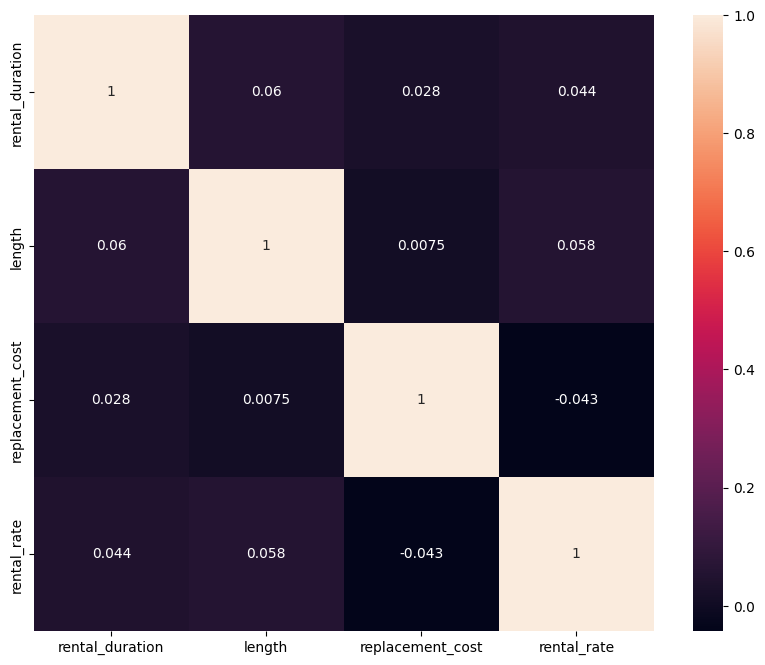

In [21]:
import matplotlib.pyplot as plt
# look for multicolinearity (some columns having almost identical correlation to other variables)
corr_matrix=X_train_num.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [22]:
X_train_num

,rental_duration,length,replacement_cost,rental_rate
29,5,129,17.99,4.99
535,4,122,15.99,0.99
695,3,82,14.99,0.99
557,3,74,10.99,2.99
836,3,80,21.99,4.99
...,...,...,...,...
106,7,115,29.99,2.99
270,7,48,19.99,2.99
860,4,93,13.99,4.99
435,6,130,22.99,2.99


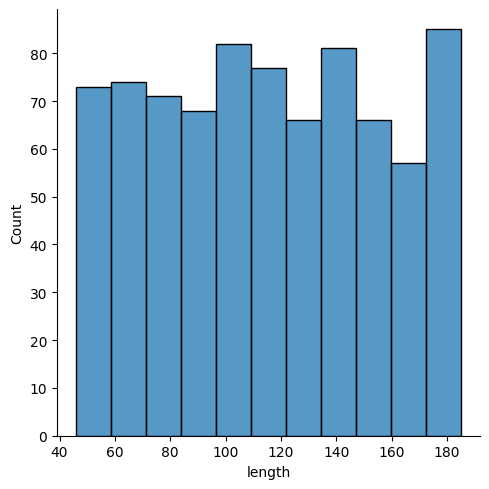

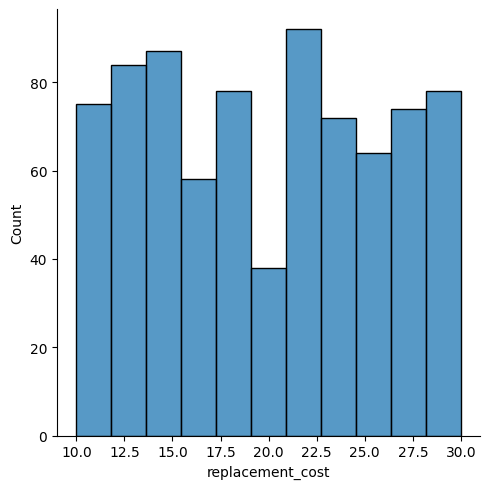

In [23]:
# explore the data by ploting distributions for numericals
sns.displot(X_train_num['length'])
plt.show()

sns.displot(X_train_num['replacement_cost'])
plt.show()



In [24]:
# importing the required libraries
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

# appying scaling tp the numericaldata to normalize them into same level of between 0 and 1
transformer = MinMaxScaler().fit(X_train_num) # to use for X_test too
X_train_scaled_arr = transformer.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train_num.columns)
X_train_scaled.head()

,rental_duration,length,replacement_cost,rental_rate
0,0.50,0.597122,0.40,1.0
1,0.25,0.546763,0.30,0.0
2,0.00,0.258993,0.25,0.0
3,0.00,0.201439,0.05,0.5
4,0.00,0.244604,0.60,1.0


In [25]:
# encoding categorical data
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

onehot_encoded = pd.DataFrame(encoded_cat, columns=cols)
onehot_encoded.head()

,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# joining transformed and encoded data togetther for prediction
X_train_treated = pd.concat([X_train_scaled, onehot_encoded], axis=1)
X_train_treated

,rental_duration,length,replacement_cost,rental_rate,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.50,0.597122,0.40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.25,0.546763,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.258993,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.201439,0.05,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.244604,0.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.00,0.496403,1.00,0.5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,1.00,0.014388,0.50,0.5,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.25,0.338129,0.20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.75,0.604317,0.65,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Applying the model(Logistic Regretion) to classify rentals

In [27]:
# importing the relevant libraries and applying the model on the data
from sklearn.linear_model import LogisticRegression
#classification = LogisticRegression()
#classification.fit(X_train_treated, y_train)

classification = LogisticRegression(random_state=0, solver='saga',
                multi_class='multinomial').fit(X_train_treated, y_train)

In [28]:
# repeating the above steps with the X_test_num data
X_test_num.head()

,rental_duration,length,replacement_cost,rental_rate
521,5,154,16.99,4.99
737,3,148,20.99,4.99
740,3,123,21.99,2.99
660,6,135,29.99,0.99
411,5,60,19.99,4.99


In [29]:
# applying scaler to X_test_num
X_test_scaled_arr = transformer.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_num.columns)
X_test_scaled.head(5)

,rental_duration,length,replacement_cost,rental_rate
0,0.50,0.776978,0.35,1.0
1,0.00,0.733813,0.55,1.0
2,0.00,0.553957,0.60,0.5
3,0.75,0.640288,1.00,0.0
4,0.50,0.100719,0.50,1.0


In [30]:
# applying encoder to X_test_cat
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=cols)
onehot_encoded_test.head()

,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# combined scaled and onehot_encoded portions of X_test
X_test_treated = pd.concat([X_test_scaled, onehot_encoded_test], axis=1)

In [32]:
predictions = classification.predict(X_test_treated)
predictions
classification.score(X_test_treated, y_test)

0.665

In [33]:
# there is an imbalance between the two classes, but not huge and should probably not affect the prediction negatively. 

print(y_test.value_counts())

rented_in_may
1    135
0     65
Name: count, dtype: int64


In [34]:
# the disparity in the numbers are amplified by the model
pd.Series(predictions).value_counts()


1    194
0      6
Name: count, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
confusion_matrix(y_test, predictions)

array([[  2,  63],
       [  4, 131]], dtype=int64)

In [36]:
array = confusion_matrix(y_test, predictions)

In [37]:
array

array([[  2,  63],
       [  4, 131]], dtype=int64)

In [38]:
# acc = (9+243)/(9+243+118+30)
acc = accuracy_score(y_test, predictions)
acc

0.665

In [40]:
#prec = 9/(9+118)
prec = precision_score(y_test, predictions)
prec

0.6752577319587629

In [41]:
recall = 9/(9+243)
recall = recall_score(y_test, predictions)
recall

0.9703703703703703

In [42]:
#f1 = 2*(precision*recall)/(precision + recall)
f1 = f1_score(y_test, predictions)
f1

0.7963525835866261